# Biodiversity Intactness Index (BII) in Arizona Phoenix
### Author: Marie Tolteca
### Date: 12-06-2025
Github: https://github.com/marietolteca00/biodiversity_intact_phoenix.git

### About
This project uses Biodiversity Intactness Index (BII) datasets produced by Impact Observatory in collaboration with Vizzuality, which provide 100 meter global maps of terrestrial biodiversity intactness from 2017–2020. These maps help identify remaining intact habitats, support spatial planning, and offer a more up-to-date alternative to traditional biodiversity datasets that often lag by several years. In this notebook the goal is to examine changes in BII in the Phoenix county subdivision area between 2017 and 2020, shedding light on how urban growth affects biodiversity over time.

### Key Concepts
- Understand how to retrieve information from a website using the planetary_computer. 
- When changing CRS, always look at what information has changed 
- Raster processing
- Geospatial masking

### About the Data
The data used in this notebook will be retrived from the Microsoft Planetary Computer through `collection_search` for both the 2017 and 2020 rasters covering Phoenix. The United States (US) Census Bureau of 2025 TIGER shapefiles will be used to acquire the outline the Arizona boundaries. This will be used to subset for only Phoenix subdivisions.

### Citation
- Microsoft Planetary Computer. io‑biodiversity Dataset. https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview
- U.S. Census Bureau. 2025TIGER/Line® Shapefiles: County Subdivisions. https://www.census.gov/cgi‑bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from shapely import box
import pystac_client
import planetary_computer
import contextily as ctx
import matplotlib.patches as mpatches
from IPython.display import Image 

### Data Citation
- Census County Subdivision shapefiles (TIGER/Line 2020) - `tl_2020_04_cousub`
- Microsoft Planetary Computer - `io-biodiversity collection` (BII time series)

### Import Arizona Shapefile

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

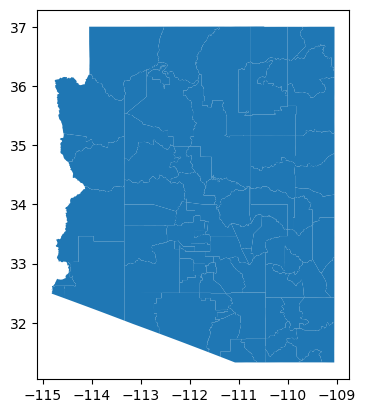

In [2]:
# Import Shapefile for Arizona
arizona = gpd.read_file(os.path.join('data',
                                'tl_2025_04_cousub',   
                                'tl_2025_04_cousub.shp'))

arizona.plot()

# Check CRS for Shapefile
arizona.crs #EPSG: 4269


### Data Exploration

In [3]:
# Check first 5 rows of Dataframe
arizona.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,013,90459,01934926,0401390459,0600000US0401390459,Buckeye,Buckeye CCD,22,Z5,G4040,S,4671129762,357303,+33.3611766,-112.9604852,"POLYGON ((-113.33506 33.48555, -113.33504 33.4..."
1,04,027,93264,01934982,0402793264,0600000US0402793264,Somerton,Somerton CCD,22,Z5,G4040,S,420675109,511938,+32.5343856,-114.6789453,"POLYGON ((-114.81630 32.50783, -114.81624 32.5..."
2,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12230984153,44576370,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
3,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228863975,29245909,+36.5991098,-112.1368034,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
4,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."


### Check for Phoenix Subdivision

This CRS for Phoenix is: EPSG:4269


<Axes: >

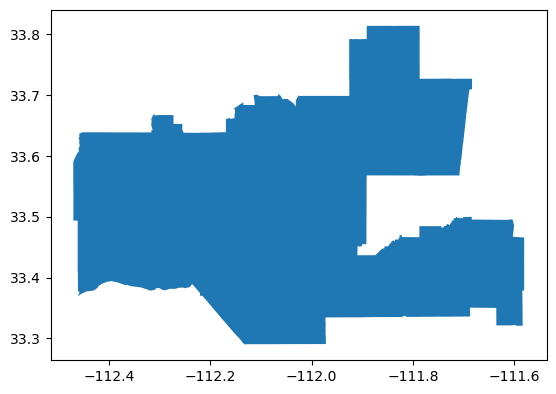

In [4]:
# Check if Phoenix exist in df
phoenix_names = arizona[arizona['NAME'].str.contains("Phoenix", case=False, na=False)]

# Create a copy to avoid any issues
phoenix = arizona[arizona['NAME'].str.contains("Phoenix", case=False, na=False)].copy()

# Verify if there are any errors
assert len(phoenix)

# CRS
print(f'This CRS for Phoenix is: {phoenix.crs}')

# Plot it 
phoenix.plot()

### Visual Map Phoenix Outline with Basemap


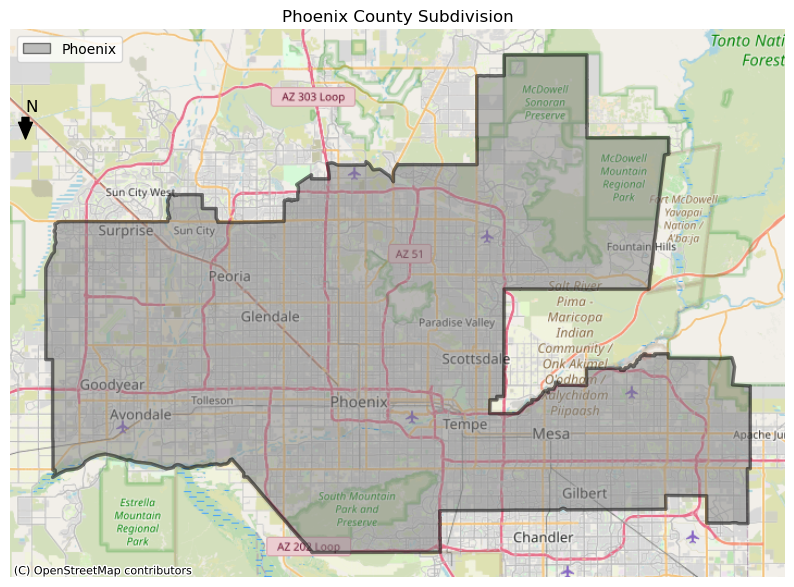

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))

# Reproject Phoenix 
phoenix = phoenix.to_crs(epsg=3857)

# Plot Phoenix subdivision
phoenix.plot(ax=ax, linewidth=2.5, 
             edgecolor="black", 
             facecolor="grey", 
             alpha = 0.5,
             label= "Phoenix")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Phoenix County Subdivision", fontsize=12)
ax.set_axis_off()

# Legend
legend_patch = mpatches.Patch(facecolor='grey', edgecolor='black', alpha=0.5, label='Phoenix')
ax.legend(handles=[legend_patch], loc='upper left')

# North Arrow
x_arrow, y_arrow = 0.02, 0.8 # Horizontal, Vertical
ax.annotate('N', xy=(x_arrow, y_arrow), xytext=(x_arrow, y_arrow+0.05),
            arrowprops=dict(facecolor='black', width=5, headwidth=10),
            fontsize=12, xycoords=ax.transAxes)


plt.show()



In the Data exploration I was bale to look at the first five rows of the data to see if the type of rows and information it contained. Since we are focused in phoenix, a filtered search was made and place in a variable. The variable was plotted to make sure the city of Phoenix was correctly extracted. I noticed the phoenix area has some regional parks and preserves but most of it has been urbanized.

## Use Catalog Search to Grab Data
Connect to the Microsoft Planetary Computer data catalog and perform the search. The collection ID for Biodiversity Intactness Index (Bll) Time Series data is `io-biodiversity`. This uses the 2017 - 2020 Rasters covering the Phoenix subdivision.

In [6]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set Bounding Box Coordinates
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search MPC Datalog
search = catalog.search(collections=["io-biodiversity"], 
                        bbox=bbox_of_interest)


# Retrieve Search Items
items = search.item_collection()
print(f'Returned{len(items)} items')

items


Returned4 items


### Retrieve the rasters from 2017 and 2020

In [7]:
# Search MPC Datalog for 2017
search_2017 = catalog.search(
    collections=["io-biodiversity"],
    bbox=bbox_of_interest,
    datetime="2017-01-01/2017-12-31"
)
items_2017 = list(search_2017.get_items())
items_2017 = items_2017[0]


# Search MPC Datalog for 2020
search_2020 = catalog.search(
    collections=["io-biodiversity"],
    bbox=bbox_of_interest,
    datetime="2020-01-01/2020-12-31"
)
items_2020 = list(search_2020.get_items())
items_2020 = items_2020[0]

/Users/marietolteca/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


## Data Cleaning of BII
#### Retrieve Raster 2017 from Catalog

In [8]:
# Access Raster Data from item
raster_2017 = rioxr.open_rasterio(items_2017.assets['data'].href)
# View raster
raster_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### Match CRS and Clip for Raster 2017

In [9]:
# Match CRS
phoenix_match = phoenix.to_crs(raster_2017.rio.crs)

# Use assert for any errors
assert phoenix_match.crs == raster_2017.rio.crs

# Clip
raster_2017_clip = raster_2017.rio.clip(phoenix_match.geometry, drop=True)
print(f'NaN Values in Raster 2017: {np.isnan(raster_2017_clip.data).sum()}')

# View results
raster_2017_clip

NaN Values in Raster 2017: 238476


<xarray.DataArray (band: 1, y: 583, x: 990)> Size: 2MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 5kB 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

### Retrieve Raster 2020 from Catalog
### Complete The Same Process From Raster 2017

In [11]:
# Access Raster Data from item
raster_2020 = rioxr.open_rasterio(items_2020.assets['data'].href)
# View raster
raster_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### Match CRS and Clip for Raster 2020

In [12]:
# Match CRS
phoenix_match = phoenix.to_crs(raster_2020.rio.crs)

# Use assert for any errors
assert phoenix_match.crs == raster_2020.rio.crs

# Clip
raster_2020_clip = raster_2020.rio.clip(phoenix_match.geometry, drop=True)
print(f'NaN Values in Raster 2020: {np.isnan(raster_2020_clip.data).sum()}')

# View results
raster_2020_clip

NaN Values in Raster 2020: 238476


<xarray.DataArray (band: 1, y: 583, x: 990)> Size: 2MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 5kB 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

### Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and 2020

High BII (≥0.75) in 2017: 7.13%
High BII (≥0.75) in 2020: 6.49%
High BII lost (2017 → 2020): 0.65%


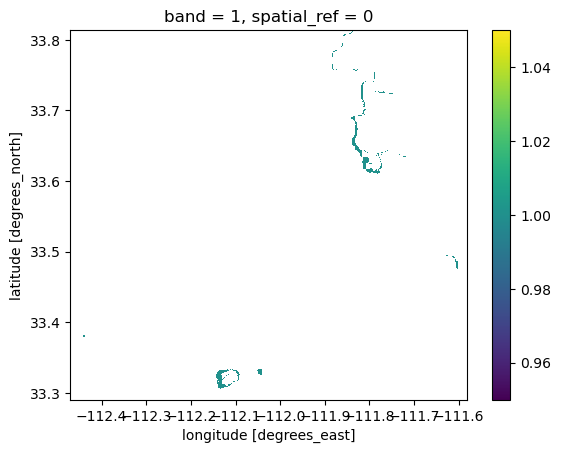

In [ ]:
# Grab the difference
bii_2017 = raster_2017_clip >= 0.75


# The Change in 2020 raster
bii_2020 = raster_2020_clip >= 0.75

# Find values form 2017 not present in 2020, lost high BII
diff_mask = bii_2017 & (~bii_2020)

# Remove NAN- this helped when plotting
numeric_mask = diff_mask.where(diff_mask, other=np.nan)
# View
numeric_mask.plot()

# Convert to numpy arrays
arr_2017 = bii_2017.data
arr_2020 = bii_2020.data
arr_loss = diff_mask.data

# Total valid pixels inside Phoenix
valid_pixels = np.isfinite(raster_2017_clip.data)
total_pixels = valid_pixels.sum()

# Counts
count_2017 = arr_2017.sum()
count_2020 = arr_2020.sum()
count_loss = arr_loss.sum()

# Convert to Percentages
pct_2017_high = (count_2017 / total_pixels) * 100
pct_2020_high = (count_2020 / total_pixels) * 100
pct_loss      = (count_loss  / total_pixels) * 100

print(f"High BII (≥0.75) in 2017: {pct_2017_high:.2f}%")
print(f"High BII (≥0.75) in 2020: {pct_2020_high:.2f}%")
print(f"High BII lost (2017 → 2020): {pct_loss:.2f}%")


### Visualizing BII

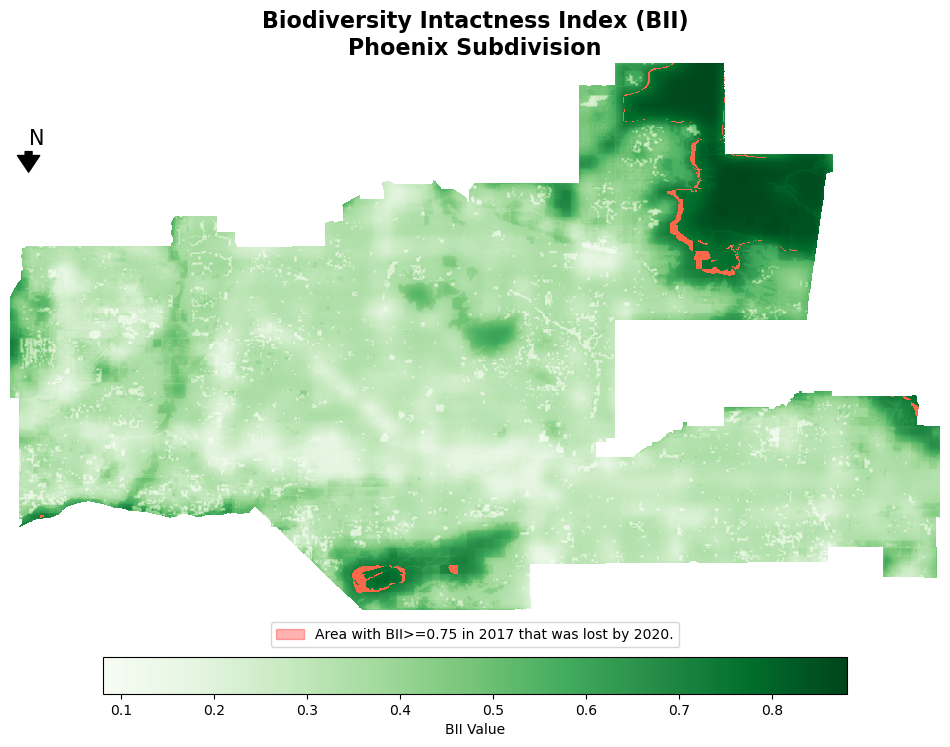

In [17]:
fig, ax = plt.subplots(figsize=(12,12))

#Raster 2020
raster_2020_clip.plot(
    ax=ax, 
    cmap="Greens",
    cbar_kwargs={
        # Scale bar
        "orientation": "horizontal",
        "label": "BII Value",
        "shrink": 0.8,
        "pad": 0.05
    }
)

# Use difference
numeric_mask.plot(ax=ax, cmap="Reds", add_colorbar=False)


phoenix.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)

# Legend
red_patch = mpatches.Patch(color='red', alpha=0.3, label='Area with BII>=0.75 in 2017 that was lost by 2020.')
ax.legend(handles=[red_patch], loc='lower center', fontsize=10, frameon=True, facecolor='white',  
          # Allowed to manually set: horizontal, vertical
          bbox_to_anchor=(0.5, -0.08))

ax.set_title(
    "Biodiversity Intactness Index (BII)\nPhoenix Subdivision",
    fontsize=16,
    weight="bold"
)
# North Arrow
x_arrow, y_arrow = 0.02, 0.8 # Horizontal, Vertical
ax.annotate('N', xy=(x_arrow, y_arrow), xytext=(x_arrow, y_arrow+0.05),
            arrowprops=dict(facecolor='black', width=5, headwidth=16),
            fontsize=15, xycoords=ax.transAxes)

ax.axis('off')
plt.show()


#### Interp:
In the figure above, the Biodiversity Intactness Index (BII) is generally low across most of the Phoenix subdivision, with higher values concentrated in the southwestern and northwestern regions. These darker green areas indicate richer biodiversity and more intact habitat, likely reflecting the presence of regional parks and nature preserves where human impact is lower. The red areas highlight locations where high-quality habitat (BII ≥ 0.75 in 2017) was lost by 2020, indicating zones of recent loss of habitat.